In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Step 1: Load Dataset
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
dataset = pd.read_csv('data/adult.data', header=None, names=columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
Missing values:
age               0
workclass         0
fnlwgt            0
education        

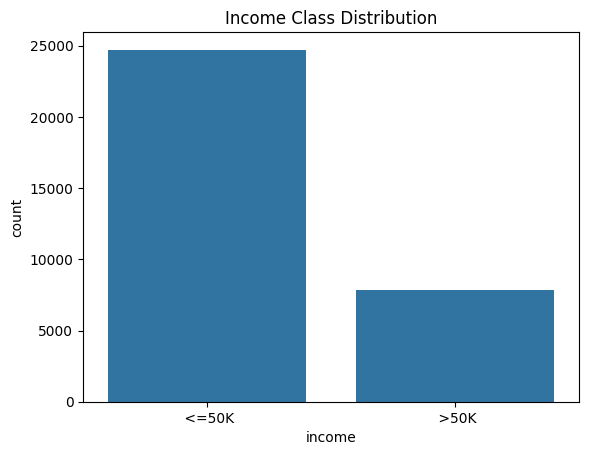

In [3]:
# Step 2: Data Exploration
dataset.head()

# Summary statistics
dataset.info()
dataset.describe()

# Check for missing values
print("Missing values:")
print(dataset.isnull().sum())

# Class distribution
sns.countplot(x='income', data=dataset)
plt.title("Income Class Distribution")
plt.show()

In [7]:
# Step 3: Data Cleaning
# Handle missing values (I learned that I have to replace any '?' 
# with NaN and drop rows with missing values because I received an error that 
# just about ruined my winter break :) )
dataset.replace(' ?', np.nan, inplace=True)
dataset.dropna(inplace=True)

# Encode categorical variables
dataset = pd.get_dummies(dataset, drop_first=True)

In [8]:
# Step 4: Train-Test Split
X = dataset.drop('income_ >50K', axis=1)
y = dataset['income_ >50K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Step 5: Build and Combine Ensemble Models
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Stacking Classifier
estimators = [('rf', rf), ('gb', gb)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42))],
                   final_estimator=LogisticRegression())

In [10]:
# Step 6: Validate Models
models = {'Random Forest': rf, 'Gradient Boosting': gb, 'Stacking': stacking_clf}
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")
    print(f"{name} Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Random Forest Accuracy: 0.8543
Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.92      0.90      4503
        True       0.74      0.65      0.69      1530

    accuracy                           0.85      6033
   macro avg       0.81      0.79      0.80      6033
weighted avg       0.85      0.85      0.85      6033

Random Forest Confusion Matrix:
[[4157  346]
 [ 533  997]]
Gradient Boosting Accuracy: 0.8671
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.95      0.91      4503
        True       0.81      0.63      0.70      1530

    accuracy                           0.87      6033
   macro avg       0.84      0.79      0.81      6033
weighted avg       0.86      0.87      0.86      6033

Gradient Boosting Confusion Matrix:
[[4274  229]
 [ 573  957]]
Stacking Accuracy: 0.8666
Stacking Classification Report:
              precisio

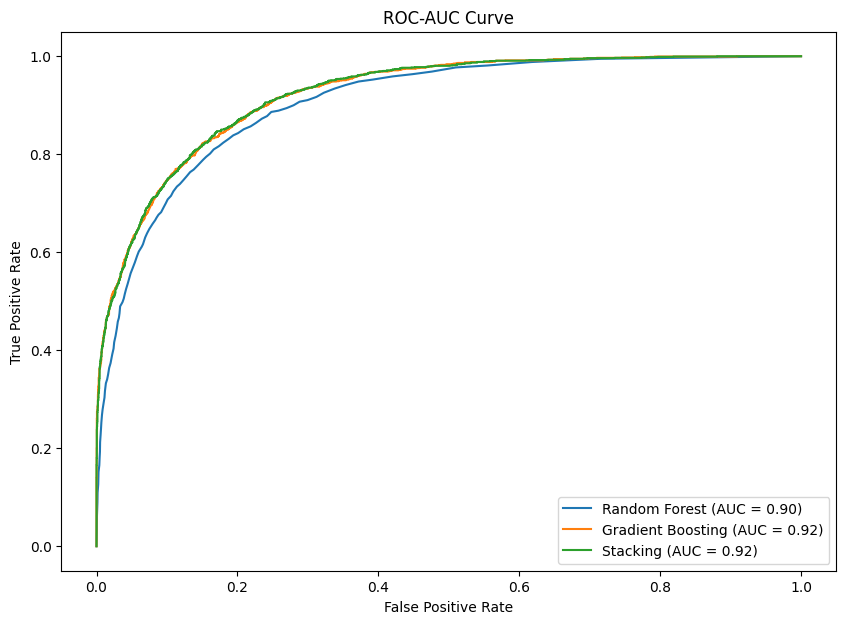

In [11]:
# Step 7: ROC-AUC Curves
plt.figure(figsize=(10, 7))
for name, model in models.items():
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})')

plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()